In [1]:
import sys
import time
import os
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map
vedo.settings.default_backend = "vtk"
# vedo.settings.renderer_frame_width = 1.
# vedo.settings.use_parallel_projection = True

import matplotlib.pyplot as plt
# from matplotlib import colormaps
# list(colormaps)
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact

from jax import jit, vmap, value_and_grad, nn
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2, fftshift, fftfreq
from jaxdf import FourierSeries 
from jaxdf.operators import compose
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
import generate_data
import vis
import util as u
import generate_data as gd
import reconstruct as r

import learned_reg as lr
from PADataset import PADataset
from flax import linen as nn

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

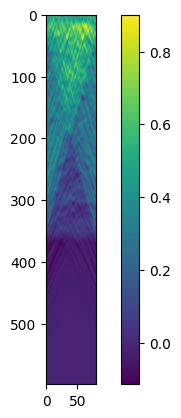

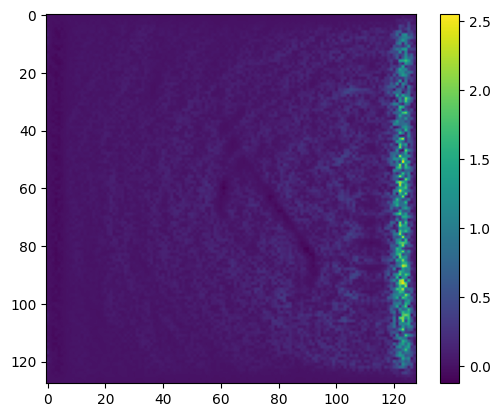

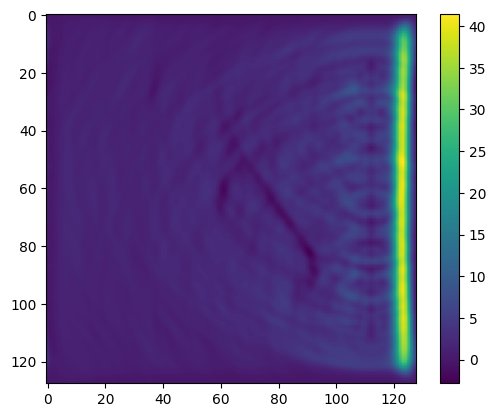

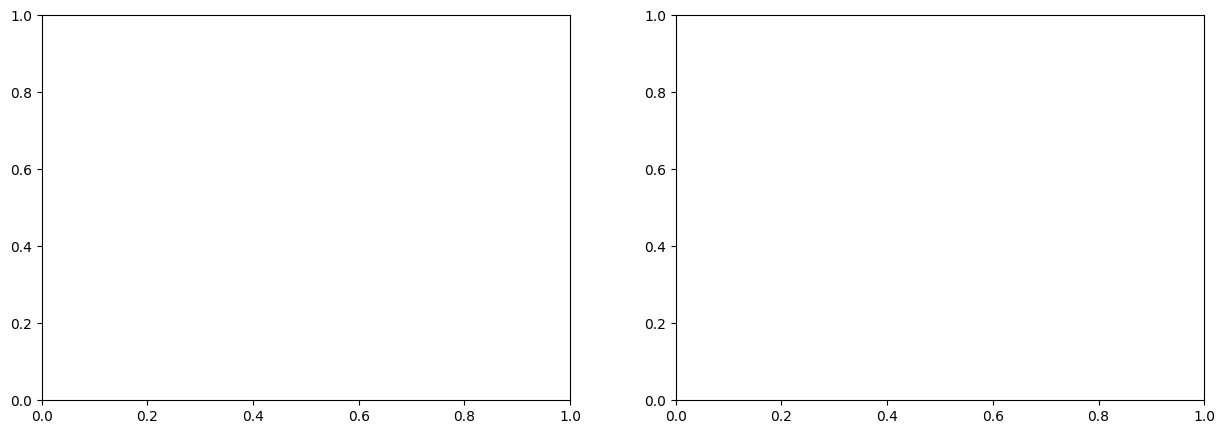

In [27]:
P_pred = np.load(u.file(u.DATA_PATH,"P_pred"))
plt.imshow(P_pred[0])
plt.colorbar()
plt.figure()
fidelity = np.load(u.file(u.DATA_PATH,"fidelity"), allow_pickle=True)
plt.imshow(fidelity[1][0].on_grid.squeeze())
plt.colorbar()
plt.figure()
plt.imshow(fidelity[0].on_grid)
plt.colorbar()
fidelity[2].on_grid.shape


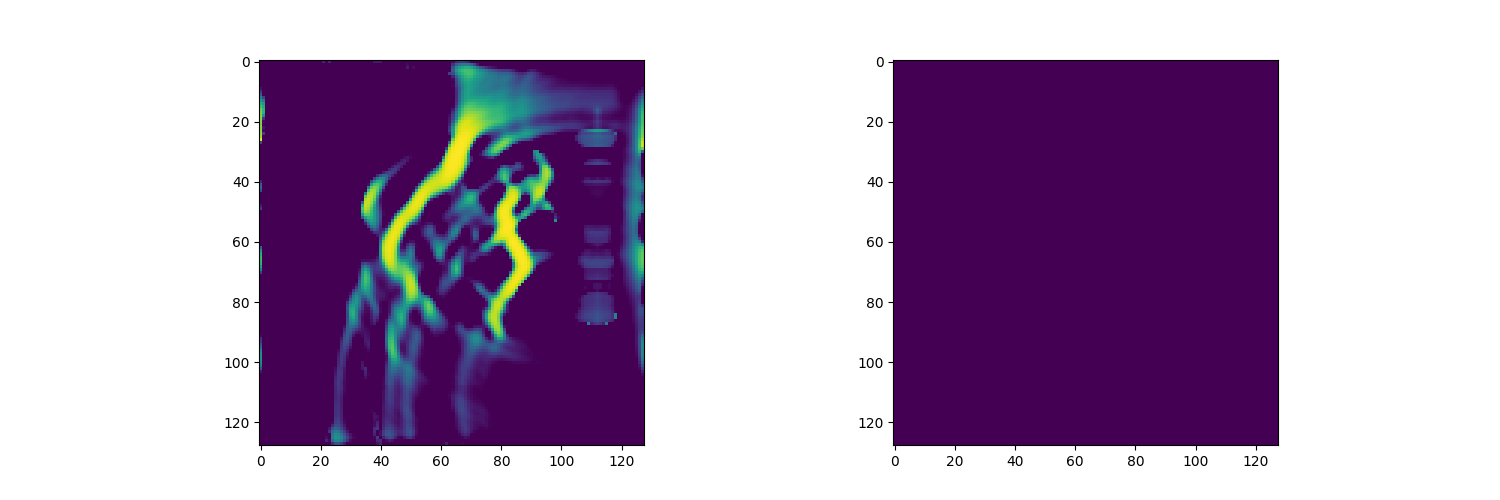

In [13]:

mu_r = np.load(u.file(u.mu_r_path, 1, 2))
c_r = np.load(u.file(u.c_r_path, 0, 0))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mu_r)
ax[1].imshow(c_r)


interactive(children=(IntSlider(value=0, description='file', max=99), IntSlider(value=4, description='it', max…

Text(value='252.14551799570054')

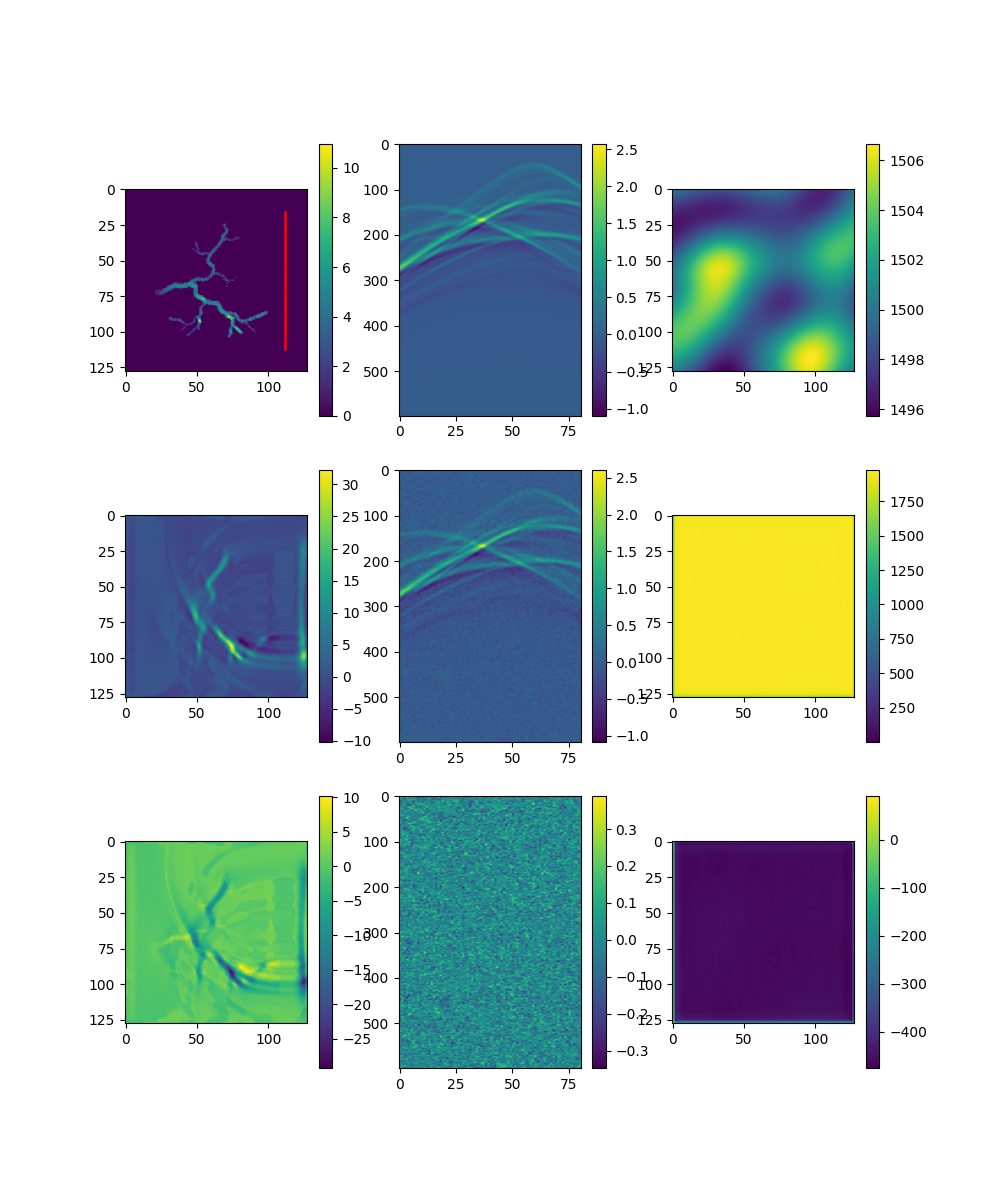

In [3]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import os

dataset = PADataset()

def load_data(idx, it):
    global max_file, max_it, mu, angles, P_0, c, P_data, P_data_noisy, sensors, mu_r, c_r

    data = dataset[idx]
    data = dataset.load_recon(idx, it)
    mu = data['mu']
    angles = data['angles']
    P_0 = data['P_0']
    c = data['c']
    P_data = data['P_data']
    P_data_noisy = data['P_data_noisy']
    sensors = data['sensors']
    mu_r = data['mu_r']
    c_r = data['c_r']

    max_it = u.max_iteration()
    max_file = len(os.listdir(u.mu_path)) - 1

load_data(0, 0)

fig, ax = plt.subplots(3, 3, figsize=(10, 12))
# fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)

im0 = ax[0][0].imshow(P_0[0], aspect='equal')
sc0 = ax[0][0].scatter(sensors[1], sensors[0], c='r', s=1)
im1 = ax[0][1].imshow(P_data[0], aspect='auto')
im2 = ax[0][2].imshow(c, aspect='equal')
im3 = ax[1][0].imshow(mu_r, aspect='equal')
im4 = ax[1][1].imshow(P_data_noisy[0], aspect='auto')
im5 = ax[1][2].imshow(c_r, aspect='equal')
im6 = ax[2][0].imshow(P_0[0] - mu_r, aspect='equal')
im7 = ax[2][1].imshow(P_data[0] - P_data_noisy[0], aspect='auto')
im8 = ax[2][2].imshow(c - c_r, aspect='equal')
txt0 = widgets.Text(str(angles[0]))

cbar0 = fig.colorbar(im0, ax=ax[0][0])
cbar1 = fig.colorbar(im1, ax=ax[0][1])
cbar2 = fig.colorbar(im2, ax=ax[0][2])
cbar3 = fig.colorbar(im3, ax=ax[1][0])
cbar4 = fig.colorbar(im4, ax=ax[1][1])
cbar5 = fig.colorbar(im5, ax=ax[1][2])
cbar6 = fig.colorbar(im6, ax=ax[2][0])
cbar7 = fig.colorbar(im7, ax=ax[2][1])
cbar8 = fig.colorbar(im8, ax=ax[2][2])

def show_data(il):
    """
    il: illumination index
    """
    # global p0, p_data, c, c_r, p_r, p_data_noisy, sensor_positions
    im0.set_array(P_0[il])
    im1.set_array(P_data[il])
    im2.set_array(c)
    im3.set_array(mu_r)
    im4.set_array(P_data_noisy[il])
    im5.set_array(c_r)
    im6.set_array(mu - mu_r)
    im7.set_array(P_data[il] - P_data_noisy[il])
    im8.set_array(c - c_r)
    
    # Update normalization
    im0.set_clim(vmin=P_0[il].min(), vmax=P_0[il].max())
    im1.set_clim(vmin=P_data[il].min(), vmax=P_data[il].max())
    im2.set_clim(vmin=c.min(), vmax=c.max())
    im3.set_clim(vmin=mu_r.min(), vmax=mu_r.max())
    im4.set_clim(vmin=P_data_noisy[il].min(), vmax=P_data_noisy[il].max())
    im5.set_clim(vmin=c_r.min(), vmax=c_r.max())
    im6.set_clim(vmin=(mu - mu_r).min(), vmax=(mu - mu_r).max())
    im7.set_clim(vmin=(P_data[il] - P_data_noisy[il]).min(), vmax=(P_data[il] - P_data_noisy[il]).max())
    im8.set_clim(vmin=(c - c_r).min(), vmax=(c - c_r).max())

    # Update colorbars
    cbar0.update_normal(im0)
    cbar1.update_normal(im1)
    cbar2.update_normal(im2)
    cbar3.update_normal(im3)
    cbar4.update_normal(im4)
    cbar5.update_normal(im5)
    cbar6.update_normal(im6)
    cbar7.update_normal(im7)
    cbar8.update_normal(im8)
    
    txt0.value = str(angles[il])
    fig.canvas.draw_idle()

def update(file, it, illum):
    load_data(file, it)
    show_data(illum)
max_it = u.max_iteration()
interact(update, file=widgets.IntSlider(min=0, max=max_file, step=1, value=0), it=widgets.IntSlider(min=0, max=max_it, step=1, value=max_it), illum=widgets.IntSlider(min=0, max=P_data.shape[0]-1, step=1, value=0))
txt0


# Visualize 2D

In [2]:
domain = Domain(N=(128, 128), dx=1.)
mu_fs = FourierSeries(mu, domain)
np.sum(mu_fs.params)
plt.figure()
from jax.numpy.fft import rfft2, ifft2 
plt.imshow(rfft2(mu_fs.params).real)

NameError: name 'mu' is not defined

# Frequency domain

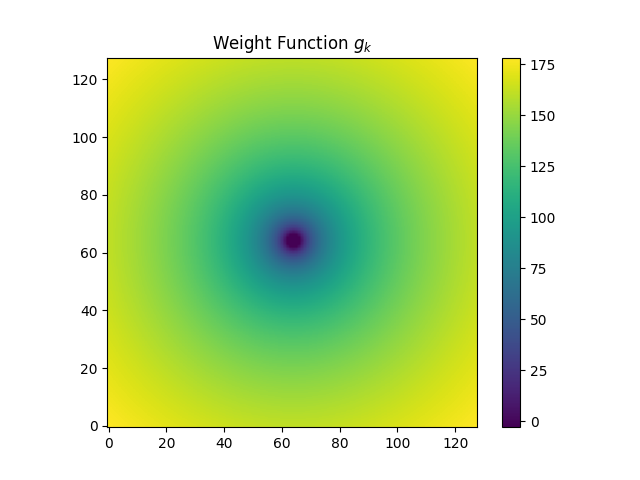

In [44]:

c = np.load(u.file(u.c_path, 0))
domain = Domain(N=(128, 128), dx=1.)
c = FourierSeries(c, domain)
shape = c.on_grid.shape
fft_c = fft2(c.on_grid)
fft_c_shifted = fftshift(fft_c)  # Shift the zero frequency to the center

freq_x = fftfreq(shape[0]).reshape(-1, 1)
freq_y = fftfreq(shape[1]).reshape(1, -1)

# Shift the frequencies so that zero is at the center
freq_x_shifted = fftshift(freq_x)
freq_y_shifted = fftshift(freq_y)

k = 0.5 * jnp.sqrt(freq_x_shifted ** 2 + freq_y_shifted ** 2)
epsilon = 1e-10  # A small constant to avoid log(0)
k_safe = 100* k + epsilon  # Ensure k is never zero to avoid log(0)
g_k = jnp.maximum(jnp.ones_like(k)*-3, 50 * jnp.log(k_safe))

plt.figure()
plt.imshow(g_k, origin='lower')  # Ensure the plot uses the correct orientation
plt.colorbar()
plt.title('Weight Function $g_k$')
plt.show()


In [37]:
def plot_fft2(x):
    plt.figure()
    # plt.imshow(fft2(x).real)
    plt.imshow(fftshift(jnp.abs(fft2(x))))


In [38]:
# x = c_r = np.load(u.file(u.c_r_path, 1, 9))
x = c
im = plt.imshow(x)
plt.colorbar(im)
# plot_fft2(x)
plot_fft2(x-np.mean(x))
# im2 = plot_fft2((x-np.mean(x))/np.std(x))
plt.colorbar(im2)

TypeError: Image data of dtype object cannot be converted to float

## c gradient

In [55]:
file_index = 9
gradient_file = f"{u.DATA_PATH}gradient_{file_index}.npy"
gradient = jnp.load(gradient_file)
plt.figure()
plt.imshow(gradient)
plt.colorbar()
gradient.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data_/gradient_9.npy'

## Apply pad_1_wrapper | add margin to ATT_masks

In [54]:
ATT_masks = np.load(u.file(u.ATT_masks_path, 0))
ATT_masks = vmap(gd.pad_1_wrapper, in_axes=(0,None))(ATT_masks, 5)
ATT_masks.shape


(20, 98, 98)

## Visualize PML margin

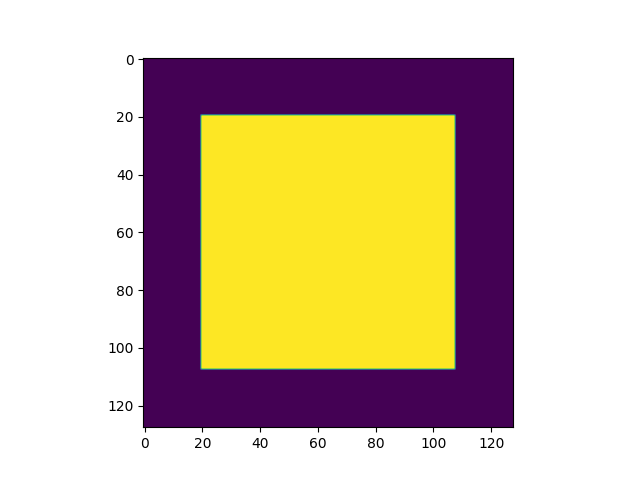

In [2]:
%matplotlib ipympl
# att = np.load(u.file(u.attenuation_masks_path, 0))
plt.figure()
att = np.ones(np.array(u.N[:2])-np.array(u.TISSUE_MARGIN[:2])*2)
att.shape
att = np.pad(att, u.TISSUE_MARGIN[:2], mode='constant', constant_values=0)
plt.imshow(att)
# plt.imshow(gd.add_margin_to_mu(att[6]))  
# plt.colorbar()

# 2D - 3D illumination mask transformation

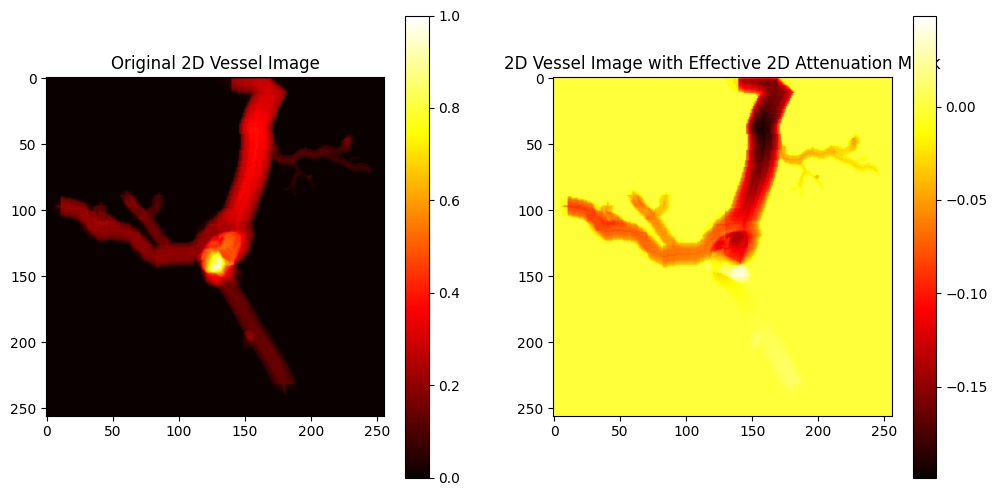

Difference: 81517.445


In [76]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

N = u.N
# Example 3D attenuation mask generation
def generate_3d_attenuation_mask(N, azimuth_deg, elevation_deg, dx, mu):
    unit_volume = jnp.ones(N)
    return gd.attenuation_mask_directional_3d([azimuth_deg, elevation_deg], unit_volume, dx=dx, mu=mu)

# Example parameters (replace with your actual parameters)
azimuth_deg = 35.0
elevation_deg = 26.0
dx = 0.1e-3
mu = 50

# Generate the 3D attenuation mask
am = generate_3d_attenuation_mask(N, azimuth_deg, elevation_deg, dx, mu)

v_a = jnp.sum(v*am, axis=0)
v_a /= jnp.max(v_a)

# Generate the effective 2D attenuation mask by summing along the depth axis
am_2d = jnp.sum(am, axis=0)

# Example 2D vessel image (replace with your actual 2D image)
v_2d = jnp.sum(v, axis=0)

# Apply the effective 2D attenuation mask to the 2D vessel image
v_2d_attenuated = v_2d / jnp.max(v_2d) #* am_2d / jnp.sum(am, axis=0)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(v_a, cmap='hot')
plt.title('Original 2D Vessel Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(v_2d_attenuated-v_a, cmap='hot')
plt.title('2D Vessel Image with Effective 2D Attenuation Mask')
plt.colorbar()

plt.show()

# Verify the approximation
v_a = gd.attenuation_mask_directional_3d([35., 26.], v, dx=dx, mu=mu)
v_a_s = jnp.sum(v_a, axis=0)
print("Difference:", jnp.sum(v_a_s - v_2d_attenuated))


# 2D attenuation mask

(256, 256)


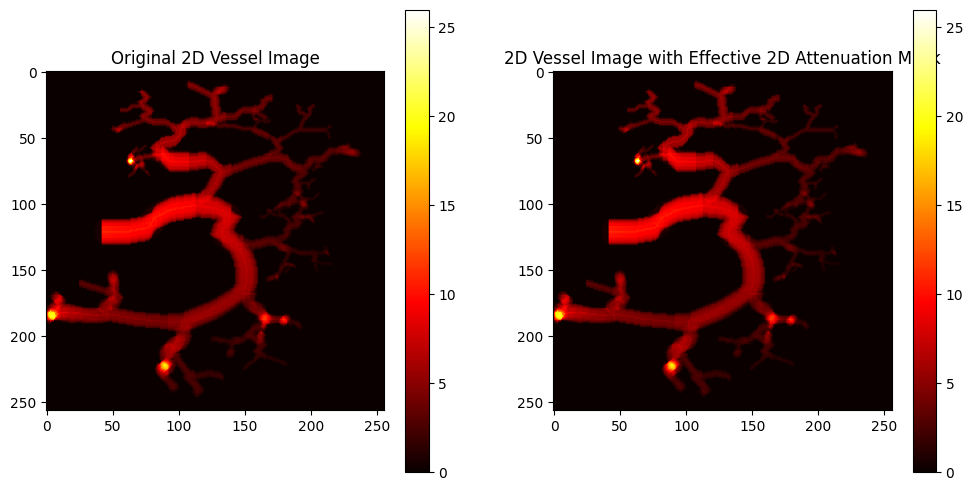

Difference: 0.0


In [8]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


N = u.N[:2]
# Example parameters (replace with your actual parameters)
azimuth_deg = 35.0
elevation_deg = 26.0
dx = 0.1e-3
mu = 50.
v, n_iter = gd.generate_vessels_3d(u.N, 1)
v_2d = jnp.sum(v.squeeze(), axis=0)
print(v_2d.shape)
v_am = gd.attenuation_mask_directional_2d(azimuth_deg, v_2d, dx, mu)

am_1 = gd.attenuation_mask_directional_2d(azimuth_deg, jnp.ones_like(v_2d), dx, mu)

v_am_1 = v_2d*am_1

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(v_am, cmap='hot')
plt.title('Original 2D Vessel Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(v_am_1, cmap='hot')
plt.title('2D Vessel Image with Effective 2D Attenuation Mask')
plt.colorbar()

plt.show()

# Verify the approximation
# v_a = gd.attenuation_mask_directional_3d([35., 26.], v, dx=dx, mu=mu)
# v_a_s = jnp.sum(v_a, axis=0)
print("Difference:", jnp.sum(v_am - v_am_1))


# Optax

In [19]:
# import optax
learning_rate=1
num_weights=8

optimizer = optax.adam(learning_rate)
# Obtain the `opt_state` that contains statistics for the optimizer.
params = {'w': jnp.ones((num_weights,))}
opt_state = optimizer.init(params)

compute_loss = lambda params, x, y: optax.l2_loss(params['w'].dot(x), y)
grads = jax.grad(compute_loss)(params, xs, ys)

(ScaleByAdamState(count=Array(0, dtype=int32), mu={'w': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, nu={'w': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}),
 EmptyState())

# Jwave

In [2]:
from jwave.geometry import Domain, Medium, TimeAxis, BLISensors
from jwave.acoustics import simulate_wave_propagation
from jaxdf import FourierSeries
from jax import jit, vmap
from functools import partial


N = (128, 128, 128)
dx = (0.1e-3, 0.1e-3, 0.1e-3)
domain = Domain(N, dx)

sensor_positions = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4]]).T
sensors_obj = BLISensors(sensor_positions, domain.N)


@jit
def compiled_simulator(medium, time_axis, p0, c):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors_obj)

batched_compiled_simulator = vmap(compiled_simulator, in_axes=(None, None, 0, None))

medium = Medium(domain=domain, sound_speed=u.C, pml_size=3)
time_axis = TimeAxis.from_medium(medium, cfl=u.CFL)
P_0 = jnp.array((jnp.ones(N), jnp.ones(N), jnp.ones(N), jnp.ones(N)))
# p0 = jnp.expand_dims(p0,-1)
# print(p0.shape)
P_0 = vmap(FourierSeries, (0, None))(P_0, domain)
c = FourierSeries(jnp.ones(N), domain)

P_data = batched_compiled_simulator(medium, time_axis, P_0,c)

# p0 = jnp.ones(N)
# p0 = jnp.expand_dims(p0, -1)
# p_data = compiled_simulator(p0)
# @util.timer
# vb = jnp.ones([5, 10,10,10])
# vb = np.sum(vb, axis=1)+
# vb.shape

[[[[[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   ...

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   ...

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]]


  [[[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   [[1.]
    [1.]
    [1.]
    ...
    [1.]
    [1.]
    [1.]]

   ...

   [[1.]
   

In [3]:
from perlin_numpy import generate_perlin_noise_3d
# Generate Sound Speed
sound_speed_volume = np.array(N) - np.array(PML_MARGIN)
noise = generate_perlin_noise_3d(
    sound_speed_volume, [SOUND_SPEED_PERIODICITY] * 3, tileable=(False, False, False)
)
sound_speed = C + SOUND_SPEED_VARIATION_AMPLITUDE * noise
sound_speed = generate_data.add_margin(
    sound_speed, N, np.array(3 * [PML_MARGIN // 2]), shift=(0, 0, -SENSOR_MARGIN[2])
)
c_file = f"data/c/0.npy"
jnp.save(c_file, sound_speed)

# Volume(jnp.load(c_file)).cmap("cool",vmin=C-SOUND_SPEED_VARIATION_AMPLITUDE/2, vmax=C+SOUND_SPEED_VARIATION_AMPLITUDE/2, alpha=0.1).mode(1).show()
# 
visualizer = vis.VolumeVisualizer("{DATA_PATH}/")
visualizer.show()
# sound_speed.max()
# np.linspace(C-SOUND_SPEED_VARIATION_AMPLITUDE/2, C+SOUND_SPEED_VARIATION_AMPLITUDE/2,20)


File data_/p_r/0_-1.npy does not exist


In [16]:
data_path = f"data_/p_r/"
c = np.load(f"{data_path}0_0.npy")
# Volume(c).mode(1).cmap("jet",alpha=0.2).add_scalarbar().show()
# .isosurface(np.linspace(-.5,.5,10)).show()
# np.mean(c[])
c.min()

np.float32(nan)

# Load data

In [2]:
data_path = f"data_/p0/"
p = np.load(f"{data_path}0.npy")
# p = jnp.load(f"{data_path}0.npy")

# Handle Signals

In [ ]:
if __name__ == "__main__":
    # Signal handling
    def signal_handler(signum, frame):
        global exit_flag
        exit_flag = True
        print("Exit signal received, finishing current task...")

    exit_flag = False
    signal.signal(signal.SIGINT, signal_handler)

# Perlin noise

In [89]:
data[data<below]=0
len(data)

94

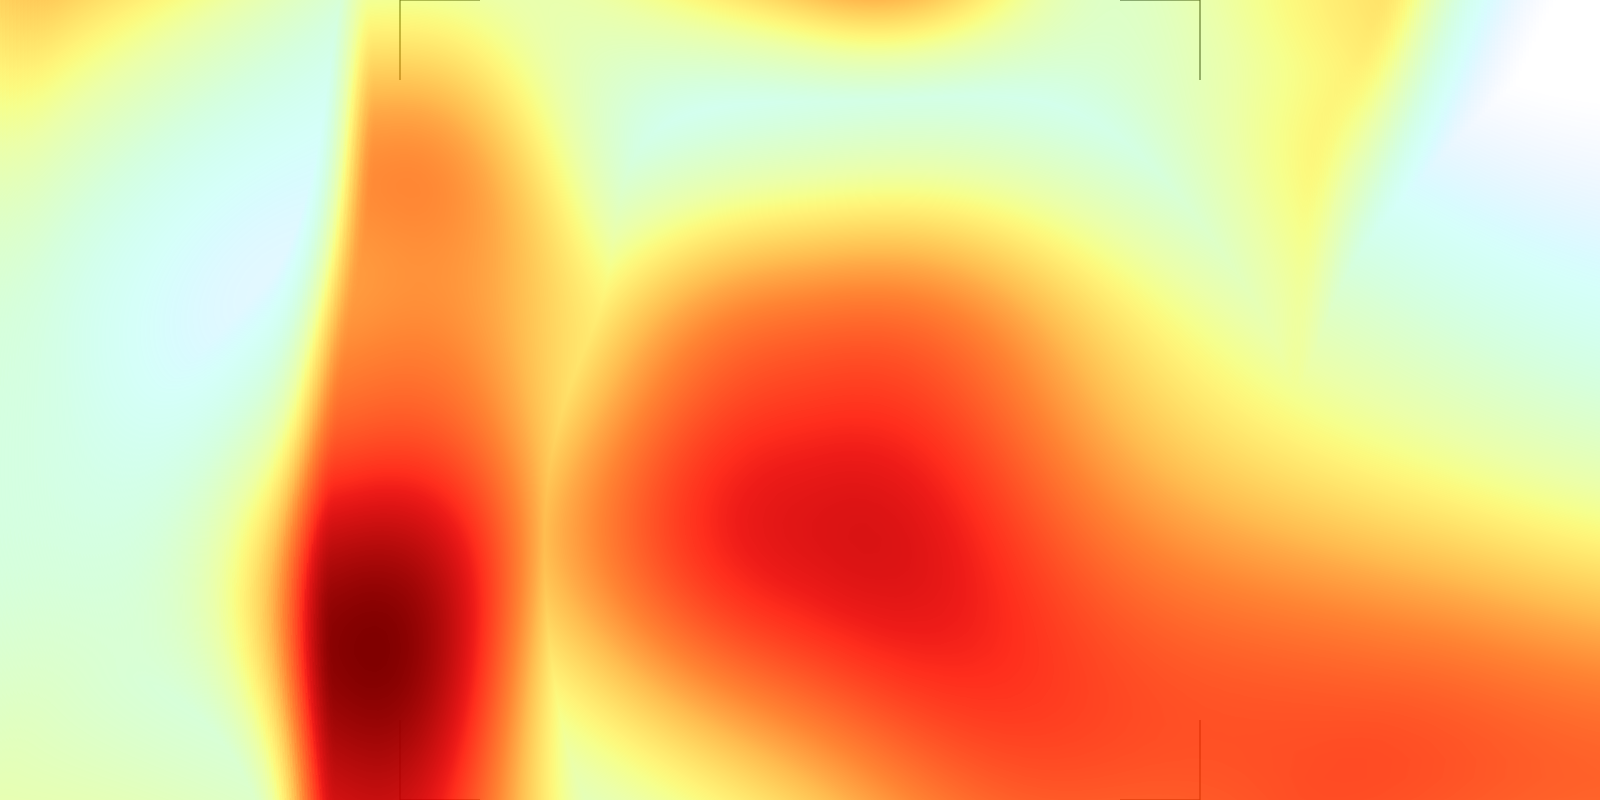

In [12]:
from perlin_numpy import generate_perlin_noise_3d
import numpy as np
from vedo import Volume, Plotter
# np.random.seed(0)
data = generate_perlin_noise_3d(
    [94, 94, 94], [2]*3, tileable=(False, False, False)
)

plotter = Plotter(axes=6, bg="white", size=(1600, 800))
v = Volume(data).cmap('jet').mode(1)#.isosurface(np.linspace(-.5,.5,10))
def apply_threshold(widget, event, v):
    below = widget.value
    data1 = data.copy()
    data1[data<below] = 0
    v=Volume(data1).cmap('jet').mode(1) 
    # plotter.objects[0] = None
    # print(plotter.objects[0])
    # plotter.clear()
    plotter.add(v)
    plotter.render()

plotter.add_slider(lambda widget, event: apply_threshold(widget, event, v), -.5, .5, .5,pos=1)
plotter.add(v)
plotter.show()

# Volume(noise).mode(1).cmap('yellow', alpha=[0.,0.5]).show()

# Vedo
## Plot volume

In [3]:
data_path = f"data_/p0/"
p = np.load(f"{data_path}3.npy")

plotter.show(Volume(p).isosurface(0.5))

In [ ]:
from scripts.PACT.vis_z import load_data
data_path = "data_/"
file_index = 0
iteration_index = 0
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))
items = load_data(data_path, file_index, iteration_index, plotter)
plotter.show()

## Toggle visibility
## Button callbacks

In [ ]:
from vedo import Plotter, Volume

# Example volumes (replace these with your actual volume data)
# p0_vol = Volume(vedo.dataurl + 'embryo.tif')
# p_r_vol = Volume(vedo.dataurl + 'embryo.tif')
p_r_vol.alpha([0, 0.4, 0.9, 1])  # Adjust transparency levels

# Initialize the plotter
plt = Plotter()

# Function to toggle visibility of a volume
def toggle_volume_1(p1, p2):
    print(p1, p2)
    if vol.mode()==2:
        vol.mode(0)
    elif vol.mode()==0:
        vol.mode(2)
    b1.switch()
    p1["Visibility"] = not p1["Visibility"]

def toggle_volume_2(button, vol):
    if vol.mode()==2:
        vol.mode(0)
    elif vol.mode()==0:
        vol.mode(2)
    b2.switch()

# Add buttons to toggle the volumes
b1 = plt.add_button(
    toggle_volume_1,
    pos=(0.1, 0.1),  # position of the button
    states=["Hide p0_vol", "Show p0_vol"],
    c=["w", "w"],     # text color
    bc=["violet", "gray"],  # background color
    font="courier",
    size=18,
    bold=True,
    # funcArgs=[p0_vol]
)

b2 = plt.add_button(
    toggle_volume_2,
    pos=(0.1, 0.2),  # position of the button
    states=["Hide p_r_vol", "Show p_r_vol"],
    c=["w", "w"],     # text color
    bc=["blue", "gray"],  # background color
    font="courier",
    size=18,
    bold=True,
    # funcArgs=[p_r_vol]
)

# Show the plotter and its contents
plt.show()


# v_system
## generate batches

In [ ]:
BATCH_SIZE = 4
tissue_volume=[188,188,188]
sim = VSystemGenerator(d0_mean=20.0, d0_std=5.0, tissue_volume=tissue_volume, )
vessels_batch, n_iters = sim.create_networks(BATCH_SIZE)

## Scale images 

In [ ]:
shrink_factor = 2
shrinked_volumes = [scipy.ndimage.zoom(vessels_batch[i], 1/shrink_factor, order=3) for i in range(len(vessels_batch))]

In [ ]:
il=0
Volume(shrinked_volumes[il])#.mode(1)#.isosurface(0.5)

In [ ]:
Volume(vessels_batch[il][::2,::2,::2])#.mode(1)#.isosurface(0.5)
# shrinked_volume.shape

### Difference between the sub-sampled and zoomed images

In [ ]:
np.sum(vessels_batch[il][::2,::2,::2] - shrinked_volumes[il])
# np.sum(vessels_batch[0][::2,::2,::2])
# np.sum(shrinked_volumes[0])

np.int64(333)

# Attenuation masks

In [158]:
import numpy as np

def attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu):
    # Convert angles to radians
    azimuth_rad = np.deg2rad(azimuth_deg)
    elevation_rad = np.deg2rad(elevation_deg)
    
    # Direction vector components in 3D
    ux = np.cos(elevation_rad) * np.cos(azimuth_rad)
    uy = np.cos(elevation_rad) * np.sin(azimuth_rad)
    uz = np.sin(elevation_rad)
    
    # Volume dimensions
    depth, height, width = volume.shape
    
    # Create mesh grids for x, y, and z coordinates
    x_indices = np.arange(width)
    y_indices = np.arange(height)
    z_indices = np.arange(depth)
    X, Y, Z = np.meshgrid(x_indices, y_indices, z_indices, indexing='ij')
    
    # Calculate the projected distance along the angle for each element in the volume
    distances = ux * X * dx + uy * Y * dx + uz * Z * dx
    
    # Create the attenuation mask
    mask = np.exp(-mu * distances)
    
    # Apply the mask
    result = mask * volume
    return result

# Example usage
volume = np.ones([5, 5, 5])  # 3D volume
# volume = np.random.rand(5, 5, 5)  # 3D volume
azimuth_deg = 45  # Azimuth angle in degrees
elevation_deg = 30  # Elevation angle in degrees
dx = 1.0  # Spatial resolution
mu = 0.1  # Attenuation coefficient

masked_volume = attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu)
print("Masked Volume:\n", masked_volume)

@interact(azimuth_deg=(0, 360), elevation_deg=(0, 180))
def apply_directional_mask(azimuth_deg=0, elevation_deg=0):
    masked_volume = attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu)
    return Volume(masked_volume)



Masked Volume:
 [[[1.         0.95122942 0.90483742 0.86070798 0.81873075]
  [0.94060006 0.89472646 0.85109013 0.80958198 0.7700982 ]
  [0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]]

 [[0.94060006 0.89472646 0.85109013 0.80958198 0.7700982 ]
  [0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]
  [0.7362495  0.70034219 0.6661861  0.63369582 0.60279011]]

 [[0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]
  [0.7362495  0.70034219 0.6661861  0.63369582 0.60279011]
  [0.69251633 0.65874191 0.62661469 0.59605433 0.56698442]]

 [[0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.7082564

interactive(children=(IntSlider(value=0, description='azimuth_deg', max=360), IntSlider(value=0, description='…

In [152]:
import numpy as np

def apply_directional_mask(array, angle_degrees, dx, mu):
    angle_radians = np.deg2rad(angle_degrees)
    
    # Unit vector components along the angle
    ux = np.cos(angle_radians)
    uy = np.sin(angle_radians)
    
    # Array dimensions
    height, width = array.shape
    
    # Create mesh grids for x and y coordinates
    x_indices = np.arange(width)
    y_indices = np.arange(height)
    X, Y = np.meshgrid(x_indices, y_indices)
    
    # Calculate the projected distance along the angle for each array element
    # Projecting grid coordinates (X, Y) onto the unit vector (ux, uy)
    distances = ux * X * dx + uy * Y * dx
    
    # Create the attenuation mask
    mask = np.exp(-mu * distances)
    
    # Apply the mask
    result = mask * array
    return result

# Example usage
array = np.array([[1, 1], [1, 1]])
angle_degrees = 45  # Angle in degrees
dx = 1.0  # Spatial resolution, assuming uniform for simplicity
mu = 0.5  # Attenuation coefficient

masked_array = apply_directional_mask(array, angle_degrees, dx, mu)
print("Masked Array:\n", masked_array)
from ipywidgets import interact

@interact(angle_degrees=(0, 180, 10))
def plot_masked_array(angle_degrees):
    masked_array = apply_directional_mask(array, angle_degrees, dx, mu)
    plt.figure(figsize=(6, 6))


    plt.imshow(masked_array, cmap='viridis')

# plt.imshow(masked_array, cmap='viridis')


Masked Array:
 [[1.         0.7021885 ]
 [0.7021885  0.49306869]]


interactive(children=(IntSlider(value=90, description='angle_degrees', max=180, step=10), Output()), _dom_clas…

In [148]:

n = [2,2]
v = np.array([[1, 2],[4,5]])
ax = 1
dx = .1
mu = 10
x = np.linspace(dx/2, n[ax]*dx-dx/2, n[ax])
mask = np.exp(-mu * x)
# np.array([mask*v[i] for i in len(v[ax])])
if ax == 0:
    mask = mask[:, np.newaxis]  # For axis=0, the mask should vary along rows
elif ax == 1:
    mask = mask[np.newaxis, :] 

r = mask * v
r
mask
# attenuated_v = v - mu * dx * (v - np.roll(v, dir, axis=0))
# attenuated_v

array([[0.60653066, 0.22313016]])

In [162]:
vessels_batch.shape

(5, 236, 236, 236)

## 2D data

In [282]:
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.ndimage

DIMS = 2
N = (256, 256, 256)
batch_size = 2

PML_MARGIN = 5


def generate_vessels_3d(N, batch_size, shrink_factor=1):
    sim = VSystemGenerator(tissue_volume=N * shrink_factor, d0_mean=20.0, d0_std=5.0)
    vessels_batch, n_iters = sim.create_networks(batch_size)
    if shrink_factor != 1:
        vessels_batch = [
            scipy.ndimage.zoom(vessels_batch[i], 1 / shrink_factor)
            for i in range(len(vessels_batch))
        ]
    return np.array(vessels_batch), n_iters


tissue_margin = 2 * (np.array([PML_MARGIN] * 3) + np.array([PML_MARGIN] * 3))
tissue_volume = np.array(N) - tissue_margin
print(f"Tissue volume: {tissue_volume}")

if DIMS == 2:
    vessels_batch, n_iters = generate_vessels_3d(
        tissue_volume, BATCH_SIZE, shrink_factor=1
    )
    mask_vmap = vmap(attenuation_mask_directional_3d, in_axes=(0, None, None, None, None))

    azimuth_deg = 90  # Example angle, assuming constant for all volumes
    elevation_deg = 0  # Example angle, assuming constant for all volumes
    dx = 0.1e-3  # Spatial resolution
    mu = 50  # e-2  # Attenuation coefficient
    vessels_batch_3d = mask_vmap(vessels_batch, azimuth_deg, elevation_deg, dx, mu)
    vessels_batch = np.sum(vessels_batch, axis=1)

elif DIMS == 3:
    vessels_batch, n_iters = generate_vessels_3d(
        tissue_volume, BATCH_SIZE, shrink_factor=2
    )

Tissue volume: [236 236 236]


In [283]:
@interact(i=(0, BATCH_SIZE - 1))
def show_vessels(i):
    plt.imshow(vessels_batch[i])
    plt.colorbar()
    plt.show()


interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

In [284]:
@interact(i=(0, BATCH_SIZE - 1))
def show_vessel_volume(i):
    vessel_vol = Volume(vessels_batch_3d[i])
    vessel_vol.scalar_range()
    vrange = vessel_vol.scalar_range()
    print(vrange)
    colors = [
        (0, [1.0, 1.0, 1.0]),
        (vrange[1], [1.0, 0.0, 0.0]),
    ]
    return vessel_vol.cmap(colors).add_scalarbar("p_r").mode(1)

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

# Light
[jaxdf](https://ucl-bug.github.io/jaxdf/notebooks/api_discretization.html#operators-and-multiple-dispatch)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np

mu_d = 1  # Diffusion coefficient
mu_a = .1  # Absorption coefficient
baseline = jnp.ones(tissue_volume)*0.00001
absorption = mu_a * jnp.array(vessels_3d[0]) + baseline  

# Source term, light coming from one side
S = jnp.zeros(tissue_volume)
S = S.at[:, :, 0].set(1.)  # Illuminate from one side

@partial(jit, static_argnums=(3,))
def diffusion_step(phi, S, absorption, mu_d, dx):
    # Calculate the Laplacian of phi
    d2phi_dx2 = (jnp.roll(phi, 1, axis=0) - 2 * phi + jnp.roll(phi, -1, axis=0)) / dx**2
    d2phi_dy2 = (jnp.roll(phi, 1, axis=1) - 2 * phi + jnp.roll(phi, -1, axis=1)) / dx**2
    d2phi_dz2 = (jnp.roll(phi, 1, axis=2) - 2 * phi + jnp.roll(phi, -1, axis=2)) / dx**2
    laplacian_phi = d2phi_dx2 + d2phi_dy2 + d2phi_dz2

    # Update phi based on the diffusion equation
    return phi + 0.1 * (mu_d * laplacian_phi - absorption * phi + S)

def solve_diffusion(S, absorption, mu_d, N):
    phi = jnp.zeros(N)
    dx = 1.0
    convergence_threshold = 1e-12
    previous_total_absorption = 0
    total_absorption = jnp.zeros(N)
    for _ in range(1000):  # Limiting to a maximum number of iterations for practicality
        phi = diffusion_step(phi, S, absorption, mu_d, dx)
        total_absorption += absorption * phi        
        if jnp.linalg.norm(total_absorption - previous_total_absorption) < convergence_threshold:
            break
        previous_total_absorption = total_absorption

    print(_)
    return phi, total_absorption

phi, total_absorption = solve_diffusion(S, absorption, mu_d, N=tissue_volume)

999


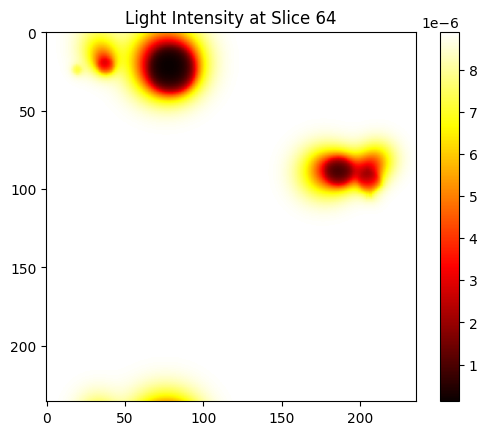

Array([[0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       ...,
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

# Example visualization of a slice
plt.imshow(phi[:, :, 64], cmap='hot')
plt.colorbar()
plt.title('Light Intensity at Slice 64')
plt.show()
total_absorption[70]

In [ ]:

# total_absorption = total_absorption/total_absorption.max()
# phi = phi/phi.max()
# phi[0].shape
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))
# plotter.add(vessel_0_vol)
plotter.add(Volume(total_absorption[:,:,5:]).cmap("hot").add_scalarbar().mode(1))
plotter.show()

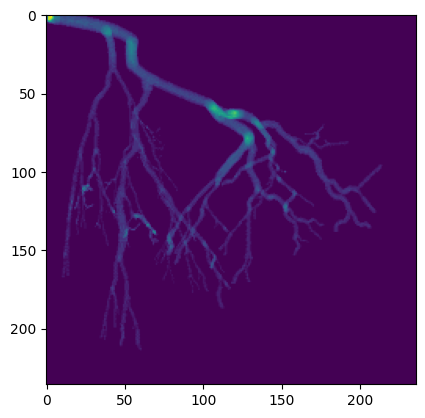

In [ ]:
plt.imshow(vessels_2d[1])
# Volume(vessels_3d[0]).mode(1).isosurface(1.).show()

Tissue volume: [222 222 222]


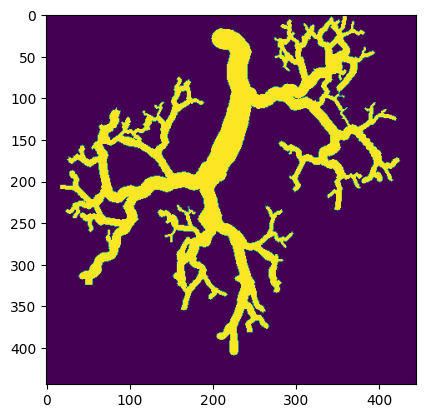

In [ ]:
from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
dims = 2
N = (256,256, 256)
BATCH_SIZE = 2
# TISSUE_MARGIN = TISSUE_MARGIN[:1]

# Generate vessels
tissue_margin = 2 * (np.array(TISSUE_MARGIN) + np.array([PML_MARGIN] * 3))
tissue_volume = np.array(N) - tissue_margin
print(f"Tissue volume: {tissue_volume}")
if dims == 3:
    shrink_factor = 2  # VSystemGenerator requires a minimum volume size to function properly
sim = VSystemGenerator(tissue_volume=tissue_volume * shrink_factor, d0_mean=20.0, d0_std=5.0)
vessels_batch, n_iters = sim.create_networks(BATCH_SIZE)
if dims == 3:
    # shrink the vessels
    vessels_batch = [
        scipy.ndimage.zoom(vessels_batch[i], 1 / shrink_factor)
        for i in range(len(vessels_batch))
    ]
if dims == 2:
    vessels_batch = np.sum(vessels_batch, axis=1, dtype = (np.bool)).astype(np.float32)


# Jwave

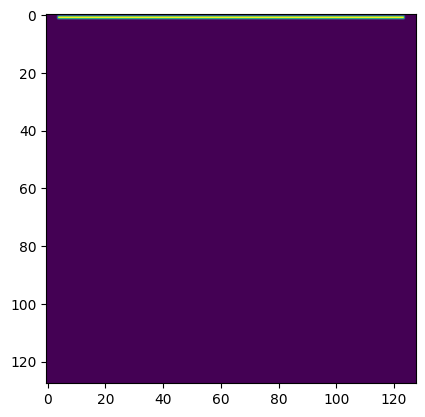

In [311]:
from jwave.geometry import get_line_transducer, Domain
N=(128,128)
d = Domain(N, DX)
a = get_line_transducer(d,1, 120)
# plt.imshow(a.on_grid)
plt.imshow(a.mask.on_grid)


## generate_data in parallel
This is slower than sequential generation.

In [ ]:
@util.timer
    @jit
    def compiled_simulator(p0, sound_speed):
        medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=PML_MARGIN)
        p0 = jnp.expand_dims(p0, -1)
        p0 = FourierSeries(p0, domain)
        return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors_obj)

    batch_simulation = vmap(compiled_simulator, in_axes=(0))

    # Preparing data
    p0s = jnp.empty([BATCH_SIZE,*N])
    cs = jnp.empty([BATCH_SIZE,*N])
    il=0
    for file in os.listdir(f"{OUT_PATH}LNet/"):
        if exit_flag:
            break

        print(f"Generating data for {file}")
        # The LNet files which don't have a corresponding p0 file
        if os.path.exists(OUT_PATH + f"p0/{file.split('_')[0]}"):
            continue
        file_index = file.split("_")[0]
        vessels = jnp.load(f"{OUT_PATH}LNet/{file}")

        # Generate Sound Speed
        if SOUND_SPEED_VARIATION_AMPLITUDE < 1e-6:
            sound_speed = C * jnp.ones(N)
        else:
            sound_speed_volume = np.array(N)-np.array(PML_MARGIN)
            noise = generate_perlin_noise_3d(
                sound_speed_volume, [SOUND_SPEED_PERIODICITY] * 3, tileable=(False, False, False)
            )
            sound_speed = C + SOUND_SPEED_VARIATION_AMPLITUDE * noise
            sound_speed = add_margin(sound_speed, N, np.array(3*[PML_MARGIN // 2]), shift=(0, 0, -SENSOR_MARGIN[2]))
        

        # Add margin to the vessels
        P_0 = add_margin(vessels, N, tissue_margin // 2, shift=(0, 0, -SENSOR_MARGIN[2]))

        # p0 = jnp.expand_dims(p0, -1)
        # p0 = FourierSeries(p0, domain)
        p0s.at[il].set(P_0)
        cs.at[il].set(sound_speed)

        p0_file = f"{OUT_PATH}p0/{file_index}.npy"
        jnp.save(p0_file, P_0)
        c_file = f"{OUT_PATH}c/{file_index}.npy"
        jnp.save(c_file, sound_speed)
    
        il+=1

    p_datas = batch_simulation(p0s, cs)

    # Save the results
    for idx, (P_data, P_0) in enumerate(zip(p_datas, p0s)):
        p_data_file = f"{OUT_PATH}p_data/{idx}.npy"
        p0_file = f"{OUT_PATH}p0/{idx}.npy"
        jnp.save(p_data_file, P_data)
        jnp.save(p0_file, P_0)  # Assuming p0 saving is still relevant
        print(f"Saved {p0_file}, {p_data_file}")

---

In [ ]:
import glob

# view volumes in data_path/LNet using vedo
data_path = "data_/LNet/"
file_index = 8
max_index = len(os.listdir(os.path.join(data_path)))-1
# plotter.show(Volume(np.load(f"{data_path}{file_index}_9.npy")))

def load_data(data_path,file_index):
    file_name = glob.glob(f"{data_path}{file_index}_*.npy")[0]
    print(file_name)
    v = jnp.load(file_name)[::2, ::2, ::2]
    v = Volume(v).isosurface(.5)
    return v

def file_index_next_button_callback(widget, event):
    global file_index, items
    print(widget)
    file_index = np.clip(file_index+1, 0, max_index)
    print(file_index)
    items = load_data(data_path, file_index)
    plotter.pop()
    plotter.pop()
    plotter.pop()
    plotter.add(items)
    # might need to clear here
    # plotter.clear()
    # plotter.add(items)
    plotter.render()
def file_index_prev_button_callback(widget, event):
    global file_index, items
    file_index = np.clip(file_index-1, 0, max_index)
    items = load_data(data_path, file_index)
    # might need to clear here
    plotter.clear()
    plotter.add(items)
    plotter.render()
file_index_next_button = plotter.add_button(file_index_next_button_callback, states=('>'), pos=(.06, .05))
file_index_prev_button = plotter.add_button(file_index_prev_button_callback, states=('<'), pos=(.02, .05))


v = load_data(data_path, file_index)
plotter.add(v)
plotter.show()
# print(volume)

# plotter.show(volume)



IndexError: list index out of range

In [ ]:
data_path = "data_/"
IN_NUM = "0"
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))

p0_file = f"{data_path}p0/{IN_NUM}.npy"
if os.path.exists(p0_file):
    P_0 = jnp.load(p0_file)
    p0_vol = Volume(P_0)
    # p0_vol.cmap(["white", "b", "g", "r"]).mode(1)
    print(f"Loaded {p0_file}")
else:
    print(f"File {p0_file} does not exist")
# plotter.show(p0_vol)#, interactive=True)


Loaded data_/p0/0.npy


In [ ]:
mask = jnp.ones_like(P_0).at[..., N[2]-PML_MARGIN-SENSOR_MARGIN[2]:].set(0)
vedo.Volume(mask).cmap("binary").mode(1).show(interactive=True)
mask.shape

(128, 128, 128)

In [ ]:
# p_r_volshape

In [ ]:
p_r_file = f"{data_path}p_r/{IN_NUM}.npy"
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))

if os.path.exists(p_r_file):
    mu_r = jnp.load(p_r_file)
    # vmax = np.max(np.abs(p_r)) 
    # vmin = -vmax
    p_r_vol = Volume(mu_r[...,0]).cmap("b").mode(1)
    #threshold 
    p_r_vol.add_scalarbar(title="p_r", c="b")
    p_r_vol.threshold(below=0.002, replace=0)
    # p_r_vol.cmap(["white", "b", "g", "r"]).mode(1)
    # show_items.append(p_r_vol)
    print(f"Loaded {p_r_file}")
else:
    print(f"File {p_r_file} does not exist")

# plotter.show(p_r_vol)#, interactive=True)
plotter.show(p0_vol,p_r_vol)#, interactive=True)


Loaded data_/p_r/0.npy


Loaded data_/p_data/0.npy


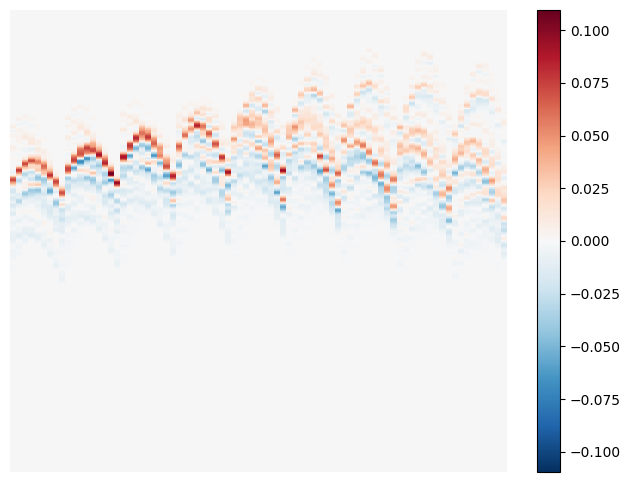

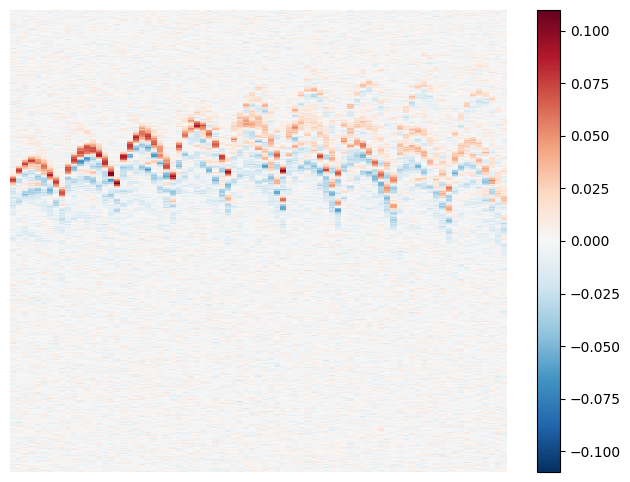

: 

In [ ]:
from jwave.utils import show_field
from jwave.signal_processing import smooth
from jax import random

data_path = "data_/"
IN_NUM = "0"
p_data_file = f"{data_path}p_data/{IN_NUM}.npy"
if os.path.exists(p_data_file):
    P_data = jnp.load(p_data_file)
    print(f"Loaded {p_data_file}")

# plt.imshow(p_data[...,0], cmap="bwr", interpolation="none")
def add_colored_noise(key, p_data, amplitude=0.2):
    """
    Add colored noise to the data

    Parameters
    ----------
    key : PRNGKey
        Random key
    p_data : ndarray
        Pressure data
    blackman_window_exponent : float
        Exponent of the Blackman window
    amplitude : float
        Amplitude of the noise
    
    Returns
    -------
    ndarray
    """
    noise = random.normal(random.PRNGKey(key), p_data.shape)
    for i in range(noise.shape[1]):
        noise = noise.at[:, i].set(smooth(noise[:, i],0))
    return p_data + amplitude * noise


P_data_noisy = add_colored_noise(random.PRNGKey(0)[0], P_data, amplitude=.005)

def normalize_data(data):
    mean = jnp.mean(data)
    std = jnp.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

show_field(P_data)
show_field(P_data_noisy)

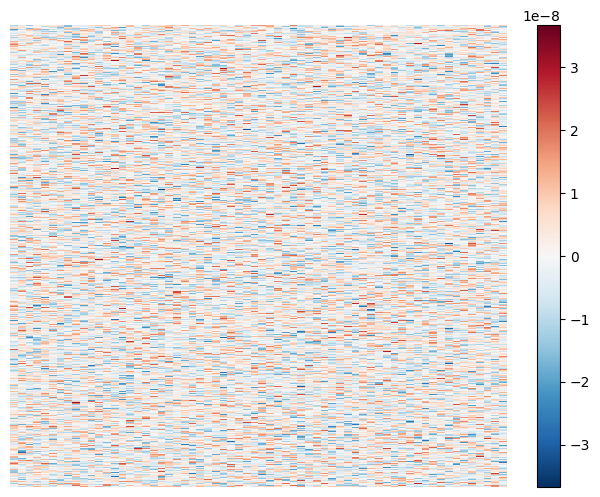

In [ ]:
# Add colored noise
noise = random.normal(random.PRNGKey(42), P_data.shape)
for il in range(noise.shape[1]):
    noise = noise.at[:, il].set(smooth(noise[:, il],1))
# plt.imshow(noise)
# jnp.max(noise)
show_field(noise)